In [145]:
import matplotlib.pyplot as plt
import sys
import pandas as pd
import os
import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

sys.path.insert(0, '../../utils')
from audio_stats import get_audio_stats, get_audio_meta
sys.path.insert(0, '../..')
from utils.text_stats import *
from torchaudio_methods import draw_waveform, draw_spectrogram

In [12]:
dataset_path = '../../numbers'

In [49]:
df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
df['filename'] = df.path.apply(os.path.basename)
df.head(3)

,path,gender,number,filename
0,train/e332b996d3.wav,female,157105,e332b996d3.wav
1,train/e25afda49a.wav,female,374554,e25afda49a.wav
2,train/364f147340.wav,male,688694,364f147340.wav


# EDA

In [50]:
df.gender.value_counts()

female    5886
male      3114
Name: gender, dtype: int64

### Проверяем распределение по фичам в срезах female/male

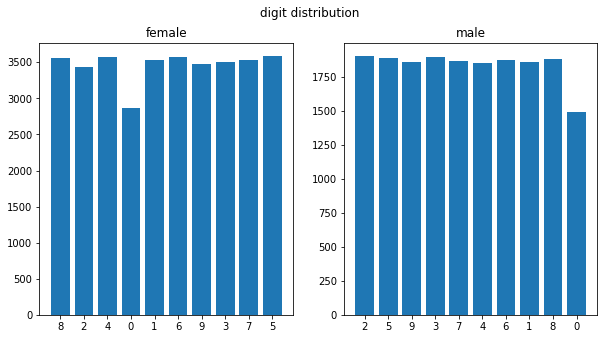

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('digit distribution')

counter = get_digit_counter(df[df.gender=='female'].number)
ax1.bar(counter.keys(), counter.values())
ax1.set_title('female')

counter = get_digit_counter(df[df.gender=='male'].number)
ax2.bar(counter.keys(), counter.values())
ax2.set_title('male')

plt.show()

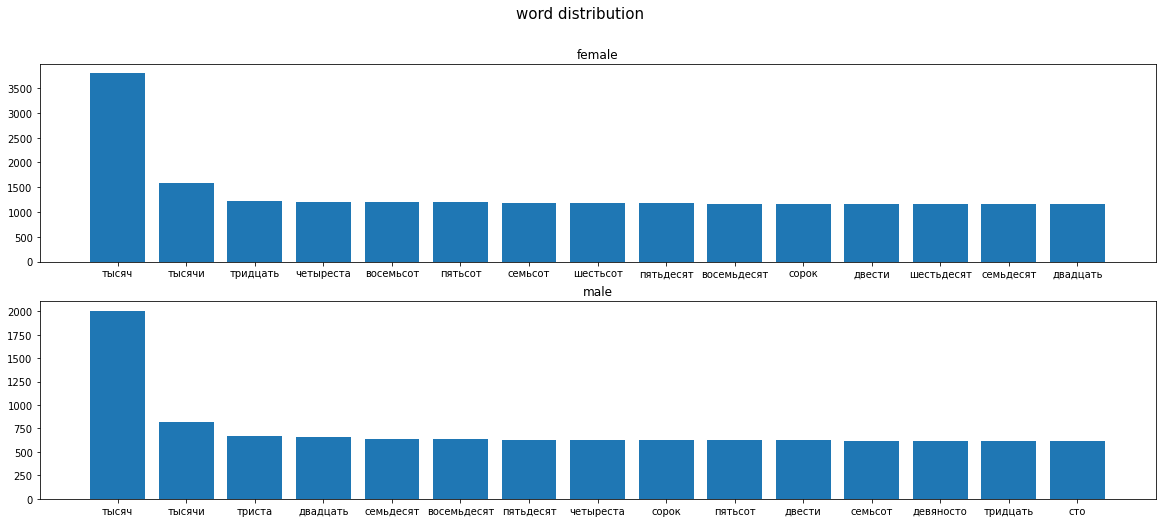

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
fig.suptitle('word distribution', fontsize=15)

counter = get_word_counter(df[df.gender=='female'].number)
most_common = counter.most_common(15)
ax1.bar([x[0] for x in most_common], [x[1] for x in most_common])
ax1.set_title('female')


counter = get_word_counter(df[df.gender=='male'].number)
most_common = counter.most_common(15)
ax2.bar([x[0] for x in most_common], [x[1] for x in most_common])
ax2.set_title('male')

plt.show()

In [41]:
counter = get_word_counter(df[df.gender=='female'].number)
most_common_f = counter.most_common(15)


counter = get_word_counter(df[df.gender=='male'].number)
most_common_m = counter.most_common(15)

print('длина пересечения 15 частотных слов:', len(set(x[0] for x in most_common_f) & set(x[0] for x in most_common_m)))

длина пересечения 15 частотных слов: 12


In [51]:
%%time
df_audio = get_audio_stats(os.path.join(dataset_path, 'train'))

CPU times: user 4.25 s, sys: 1.52 s, total: 5.78 s
Wall time: 11.8 s


In [54]:
df = df_audio.merge(df, on='filename')

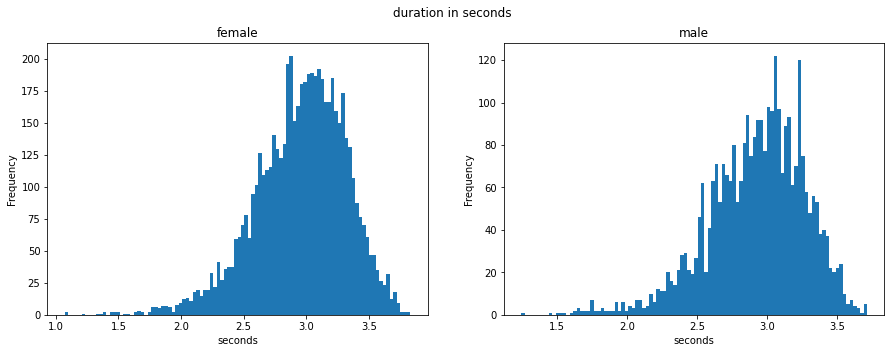

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('duration in seconds')

df[df.gender=='female'].duration_s.plot(kind='hist', bins=100, ax=ax1)
ax1.set_xlabel('seconds')
ax1.set_title('female')

df[df.gender=='male'].duration_s.plot(kind='hist', bins=100, ax=ax2)
ax2.set_xlabel('seconds')
ax2.set_title('male')

plt.show()

In [68]:
df[df.gender=='female'].describe()

,channels,frames,sample_rate_hz,size_bytes,duration_s,bitrate,number
count,5886.0,5886.000000,5886.0,5886.000000,5886.000000,5886.0,5886.000000
mean,1.0,70935.519028,24000.0,141915.038056,2.955647,16.0,497235.230717
std,0.0,8675.872956,0.0,17351.745912,0.361495,0.0,287780.768286
min,1.0,25689.000000,24000.0,51422.000000,1.070375,16.0,14.000000
25%,1.0,65678.250000,24000.0,131400.500000,2.736594,16.0,248334.000000
50%,1.0,71738.000000,24000.0,143520.000000,2.989083,16.0,494571.000000
75%,1.0,77114.750000,24000.0,154273.500000,3.213115,16.0,744352.250000
max,1.0,91956.000000,24000.0,183956.000000,3.831500,16.0,999888.000000


In [69]:
df[df.gender=='male'].describe()

,channels,frames,sample_rate_hz,size_bytes,duration_s,bitrate,number
count,3114.0,3114.000000,3114.0,3114.000000,3114.000000,3114.0,3114.000000
mean,1.0,70168.866410,24000.0,140381.732820,2.923703,16.0,502292.465318
std,0.0,8312.014712,0.0,16624.029424,0.346334,0.0,288242.190239
min,1.0,29918.000000,24000.0,59880.000000,1.246583,16.0,670.000000
25%,1.0,64952.250000,24000.0,129948.500000,2.706344,16.0,252481.500000
50%,1.0,71098.000000,24000.0,142240.000000,2.962417,16.0,497226.500000
75%,1.0,76093.500000,24000.0,152231.000000,3.170562,16.0,749425.750000
max,1.0,89085.000000,24000.0,178214.000000,3.711875,16.0,999239.000000


#### т к пол может быть полезен как фича в нелинейной модели - посмотрим, можно ли натренировать простой классификатор для получения этого признака

In [103]:
waveform, sample_rate = torchaudio.load(os.path.join(dataset_path, 'train/e332b996d3.wav'))
spectrogram = torchaudio.transforms.MFCC()(waveform)

In [92]:
df[df.path=='train/e332b996d3.wav']

,filename,channels,frames,sample_rate_hz,size_bytes,duration_s,bitrate,path,gender,number
2506,e332b996d3.wav,1,56923,24000,113890,2.371792,16,train/e332b996d3.wav,female,157105


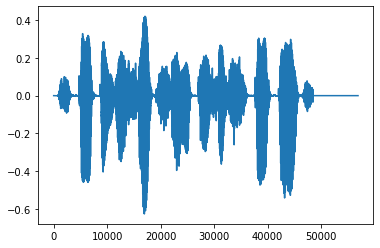

In [89]:
draw_waveform(waveform, 'waveform')

In [104]:
spectrogram.shape

torch.Size([1, 40, 285])

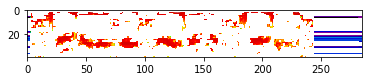

In [114]:
plt.imshow(spectrogram.log2()[0, :, :].numpy(), cmap='nipy_spectral')

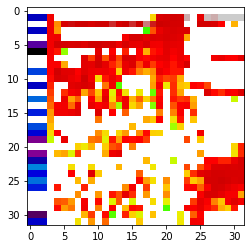

In [155]:
plt.imshow(spectrogram.log2()[0, :, :][:32,:32].numpy(), cmap='nipy_spectral')

In [168]:
def get_data(df):
    for i, row in df.iterrows():
        waveform, _ = torchaudio.load(os.path.join(dataset_path, row['path']))
        spectrogram = torchaudio.transforms.MFCC()(waveform)
        yield spectrogram[:, :32, :32].unsqueeze(0), 0 if row.gender == 'male' else 1

In [177]:
iterator = get_data(df)
X_train = []
y_train = []
for i in range(10):
    feature, target = next(iterator)
    X_train.append(feature)
    y_train.append(target)
X_train = torch.cat(X_train)
X_train.shape

torch.Size([10, 1, 32, 32])

In [173]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## модели для распознавания чисел

In [180]:
%%html
<img src="https://miro.medium.com/max/1400/1*z1Nf0ES1YVUfdZZGW0PSdQ.png" width=800>

In [185]:
print ('пул слов:')
counter = get_word_counter(df.number)
counter.most_common(30)

пул слов:


[('тысяч', 5806),
 ('тысячи', 2412),
 ('тридцать', 1841),
 ('четыреста', 1837),
 ('пятьсот', 1834),
 ('восемьсот', 1818),
 ('двадцать', 1815),
 ('семьсот', 1812),
 ('восемьдесят', 1807),
 ('пятьдесят', 1807),
 ('семьдесят', 1800),
 ('сорок', 1797),
 ('шестьсот', 1792),
 ('двести', 1786),
 ('триста', 1780),
 ('шестьдесят', 1771),
 ('сто', 1770),
 ('девятьсот', 1753),
 ('девяносто', 1734),
 ('шесть', 1669),
 ('пять', 1643),
 ('девять', 1639),
 ('восемь', 1630),
 ('четыре', 1619),
 ('три', 1603),
 ('семь', 1594),
 ('один', 820),
 ('два', 804),
 ('одна', 770),
 ('тысяча', 770)]

In [186]:
len(counter)

41